# Predictive analysis

**Goal**

To predict a LADs future areas of specialisation based on current specialisation. 

**Basic approach**

Train a model of specialisation gains in period t,t+1 using specialisations in period t as predictors. 

**Additions**

* Add predictors based on specialisation profile of neighbouring areas
* Expand the dataset by sampling multiple years
* Consider average distance between false predictions and actuals in the industry space

**Tasks**
* Create output and feature arrays 
* Create neightbour feature arrays
* Train model with crossvalidation using different parameters.
* Evaluate

In [1]:
#Imports

#Utilities
import os

#Numeric
import numpy as np
import scipy
import pandas as pd
import itertools as itr #for cartesian product
import random #to draw random elements from list

#ml
from sklearn import preprocessing
from sklearn import multiclass, ensemble, svm, linear_model, naive_bayes
from sklearn import cross_validation, grid_search
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import label_ranking_average_precision_score,average_precision_score, recall_score
from sklearn.metrics import precision_recall_curve, roc_auc_score
from sklearn.externals import joblib

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#Spatial
import pysal

if 'models' not in os.listdir():
    os.mkdir('models')

%matplotlib inline


/usr/local/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
#Functions

def generate_area_count(path_to_nomis_download,sic_cluster_lookup):
    '''
    This function takes a nomis data download and returns a df where rows=LADs and columns=business counts in 
        #clusters based on the analysis in RCA_Pilot_Data_Collection script.
    '''
    
    #The skips and subsets are to remove some guff
    idbr_sic_lad = pd.read_csv(path_to_nomis_download,skiprows=8,header=0)
    idbr_sic_lad = idbr_sic_lad.ix[:405,:]
    
    
    idbr_sic_lad.rename(columns={'local authority: district / unitary (prior to April 2015)':'lad_name',
                                     'mnemonic':'lad_code'},inplace=True)

    #Melt and create sic_4 variable to merg with clusters
    idbr_sic_lad_long = pd.melt(idbr_sic_lad,id_vars=['lad_name','lad_code'])
    idbr_sic_lad_long['sic_4_l'] = idbr_sic_lad_long['variable'].apply(lambda x:
                                                                          x.split(":")[0].strip())

    lad_clusters = pd.merge(idbr_sic_lad_long,sic_cluster_lookup,
                               left_on='sic_4_l',right_on='sic_4_string',how='inner')
    
    #Aggregate level of activity over clusters
    lad_clusters_counts = pd.pivot_table(lad_clusters,
                        index='lad_name',columns=['label'],values='value',aggfunc=np.sum,fill_value=0)
    lad_clusters_counts.reset_index(drop=False,inplace=True)
    return(lad_clusters_counts)
    

def generate_spec_profile(path_to_nomis_download,sic_cluster_lookup):
    '''
    This function takes a nomis data download and returns a df where rows=LADs and columns=LQs in 
        #clusters based on the analysis in RCA_Pilot_Data_Collection script.
    '''
    
    #The skips and subsets are to remove some guff
    idbr_sic_lad = pd.read_csv(path_to_nomis_download,skiprows=8,header=0)
    idbr_sic_lad = idbr_sic_lad.ix[:405,:]
    
    
    idbr_sic_lad.rename(columns={'local authority: district / unitary (prior to April 2015)':'lad_name',
                                     'mnemonic':'lad_code'},inplace=True)

    #Melt and create sic_4 variable to merg with clusters
    idbr_sic_lad_long = pd.melt(idbr_sic_lad,id_vars=['lad_name','lad_code'])
    idbr_sic_lad_long['sic_4_l'] = idbr_sic_lad_long['variable'].apply(lambda x:
                                                                          x.split(":")[0].strip())

    lad_clusters = pd.merge(idbr_sic_lad_long,sic_cluster_lookup,
                               left_on='sic_4_l',right_on='sic_4_string',how='inner')
    
    #Aggregate level of activity over clusters
    lad_clusters_counts = pd.pivot_table(lad_clusters,
                        index='lad_name',columns=['label'],values='value',aggfunc=np.sum,fill_value=0)
    lad_clusters_counts.reset_index(drop=False,inplace=True)
    
    
    area_shares = lad_clusters_counts.sum(axis=1)/np.sum(lad_clusters_counts.sum(axis=1))
        
    lad_clusters_lqs = pd.concat([lad_clusters_counts['lad_name'],
                                  lad_clusters_counts.ix[:,1:].apply(lambda x: (x/x.sum())/area_shares,axis=0)],
                                 axis=1)
    
    return(lad_clusters_lqs)
    
def become_specialised(spec_df_period_1,spec_df_period_2):
    '''
    Returns a df measuring change between two periods.
    If definition =1 means that the binary is 1=became specialised, 0=didn't
    '''
    
    ch = spec_df_period_2 - spec_df_period_1
    out = ch.applymap(lambda x: 0 if x<0 else x)
    return(out)
    
def gain_specialisation(clustering_period_1,clustering_period_2,threshold=0.2):
    '''
    Returns a df measuring change in specialisation between 2 periods
    If definition =1 means that the binary is 1=became specialised, 0=didn't
    '''
    
    ch = clustering_period_2.ix[:,1:]/clustering_period_1.ix[:,1:]
    out = ch.applymap(lambda x: 1 if x-1>threshold else 0)
    out['lad_name']=clustering_period_2['lad_name']
    
    return(out)

def change_specialisation(clustering_period_1,clustering_period_2):
    '''
    Returns a df measuring change in specialisation between 2 periods
    '''
    
    ch = clustering_period_2.ix[:,1:]/clustering_period_1.ix[:,1:]
    ch['lad_name']=clustering_period_2['lad_name']
    
    return(ch)

    
def eci_algorithm_simplified(adj_matrix,iterations=3):
    '''
    This algorithm replicates the work in HH. It takes a matrix and a number of
    iterations to apply the method of reflections. 
    The output is len=number of iterations. Each element contains a list with two elements:
        Element one is a vector of values for each area.
        Element 1 is a vector of values for each industry
    
    -For areas, if the value of the iteration is even (0,2,4...), the vector captures the 
    level of diversification of the area. After the first iteration, this is weighted by the diversity
    of other areas with the same industries.
    
    If the value of the iteration is odd (1,3,5), the vector captures the ubiquity of its industries.
    
    -For industries, if the value of the iteration is even (0,2,4,...) the vector captures the level of
    ubiquity of each industry. After the first iteration, this is weighted by the ubiquity of other areas with
    the same industries.
    
    If the value of the iteration is odd (1,3,5) the vector captures the diversity of the areas that specialise
    in this industry.
    
    '''
    #Initial diversity vector
    div_vect = adj_matrix.sum(axis=1)
    
    #Initial diversity vector
    ubi_vect = adj_matrix.sum()
    
    #Iterator
    
    #Create containers
    kc = [list(div_vect)]
    kp = [list(ubi_vect)]
    
    #Initialise
    i = 0
    
    while i<iterations:
        #print(i)
        eci_cont=[]
        epi_cont=[]
        
        for country in adj_matrix.index:
            eci=(1/div_vect[country])*np.sum(adj_matrix.ix[country,:]*kp[i])
            eci_cont.append(eci)
        
        for product in adj_matrix.columns:
            epi = (1/ubi_vect[product])*np.sum(adj_matrix.ix[:,product]*kc[i])
            epi_cont.append(epi)
        i +=1
        kc.append(eci_cont)
        kp.append(epi_cont)
     
    #print(kp[0].index)
    out = [[pd.Series(x,index=cluster_lqs[0]['lad_name']),
           pd.Series(y,index=ubi_vect.index)] for x,y in zip(kc,kp)]
    return(out)

def extract_neighbor_specs(spec_matrix):
    '''
    Takes a specialisation matrix and returns specialisations of an area's neighbors
    '''
    #Create dict
    id_neighbor_dict = {oid:name for oid,name in zip(neighbor_lookup.id,neighbor_lookup.name_fixed)}

    #Create neighborhood df
    neighbor_activity_list = []

    initial_specs_df = spec_matrix

    for i in w.neighbors.keys():
        #LAD we are focusing on
        this_lad = id_neighbor_dict[i]

        #Neighbors
        neighbors = [id_neighbor_dict[x] for x in w.neighbors[i]]

        #Subset matrix:
        subset_mat = initial_specs_df[[area in neighbors for area in initial_specs_df['lad_name']]]

        #Mean neighbor activity
        means = subset_mat.ix[:,1:].mean()

        neighbor_activity_list.append(means)

    #Create neighbour measures    
    neighbor_df = pd.DataFrame(
        neighbor_activity_list,index=[id_neighbor_dict[x] for x in w.neighbors.keys()]).reset_index(drop=False)
    neighbor_df.rename(columns={'index':'lad_name'},inplace=True)
    
    return(neighbor_df)

## 1. Load and process

In [3]:
#Set path for idbr file and load lookup
sic_cluster_lookup = pd.read_csv("../industry/intermediate_outputs/clusters_64_labelled.csv",
                                encoding = "ISO-8859-1")
#NB we need to create a sic string in some cases starting with 0
sic_cluster_lookup['sic_4_string'] = [
    "0"+str(x) if len(str(x))<4 else str(x) for x in sic_cluster_lookup.sic_4]

#Extract the LQs for the period 2011-2015
cluster_lqs = [generate_spec_profile('../industry/data_input/idbr_lad_{y}.csv'.format(y=str(x)),
                                    sic_cluster_lookup) for x in range(2010,2016)]

#Create dummy dfs (1 if a LAD is specialised in an area, 0 if not) 
#(NB we lose the lad name column, which isn't of interest)
binary_spec_lqs = [x.ix[:,1:].applymap(lambda x: 1 if x>1 else 0) for x in cluster_lqs]

#Create lad and sect vars for indexing dfs and columns later
lad_set = cluster_lqs[0].ix[:,0]
sector_set = binary_spec_lqs[0].columns

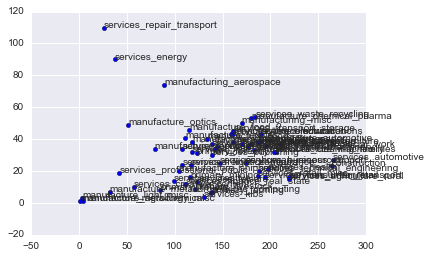

In [4]:
#Consider changes in specialisation between periods
specialise_2011_2015 = become_specialised(binary_spec_lqs[0],binary_spec_lqs[5])

plt.scatter(binary_spec_lqs[0].sum(),specialise_2011_2015.sum())

for n, (x,y) in enumerate(zip(binary_spec_lqs[0].sum(),specialise_2011_2015.sum())):
    plt.annotate(xy=(x,y),s=binary_spec_lqs[0].sum().index[n])

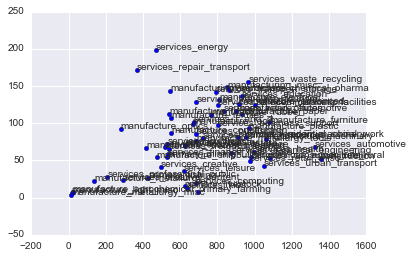

In [5]:
#Let's see what it looks like if we concatenate year-on-year changes 

yoy_changes = pd.concat([become_specialised(x,y) for x,y in zip(binary_spec_lqs[:-1],
                                                                   binary_spec_lqs[1:])]) 
yoy_specs = pd.concat(binary_spec_lqs[:-1])                    

#Seems to address some of the outliers
plt.scatter(yoy_specs.sum(),yoy_changes.sum())

for n, (x,y) in enumerate(zip(yoy_specs.sum(),yoy_changes.sum())):
    plt.annotate(xy=(x,y),s=yoy_specs.sum().index[n])

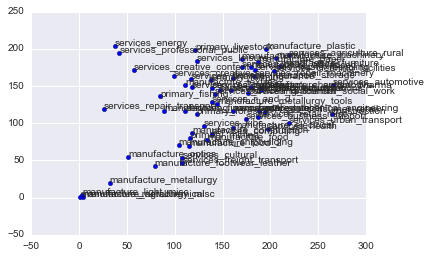

In [6]:
#Let's replicate with gains in specialisation
gain_specialisation_2011_2015 = gain_specialisation(cluster_lqs[0],cluster_lqs[5],threshold=0.05).ix[:,:-1]


plt.scatter(binary_spec_lqs[0].sum(),gain_specialisation_2011_2015.sum())

for n, (x,y) in enumerate(zip(binary_spec_lqs[0].sum(),gain_specialisation_2011_2015.sum())):
    plt.annotate(xy=(x,y),s=binary_spec_lqs[0].sum().index[n])


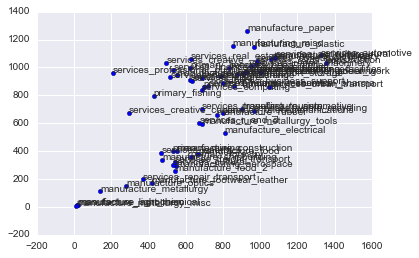

In [7]:
#And again, aggregating over years

all_yr_lq_gains = pd.concat([gain_specialisation(x,y,threshold=0) for x,y in zip(cluster_lqs[:-1],
                                                                   cluster_lqs[1:])]) 

all_yr_specs = pd.concat(binary_spec_lqs[:-1])

#yoy_specs_2 considers the actual location quotients in the area
all_yr_lq = pd.concat([x.ix[:,1:] for x in cluster_lqs[:-1]])

#Seems to address some of the outliers
plt.scatter(all_yr_specs.sum(),all_yr_lq_gains.ix[:,:-1].sum())

for n, (x,y) in enumerate(zip(all_yr_specs.sum(),all_yr_lq_gains.sum())):
    plt.annotate(xy=(x,y),s=yoy_specs.sum().index[n])

## 2. Mini-complexity analysis

We want to check if areas with higher complexity are growing more/faster.
NB we are currently doing this with growth in the number of businesses. Very simplistic analysis.
Should probably use NUTS-3 (for which there is GVA data). Need to aggregate LADS into NUTS 3 and re-run the analysis.

In [8]:
#Calculate industrial complexity using Hidalgo.
complexity_2010 = eci_algorithm_simplified(binary_spec_lqs[0],iterations=15)[14][0]
complexity_2010_norm = scipy.stats.zscore(complexity_2010)


In [9]:
complexity_df = pd.DataFrame(complexity_2010_norm,index=lad_set)
complexity_df.to_csv("intermediate_outputs/lad_complexity.csv",index=False)

In [10]:
#What's the link between complexity in 2010 and growth in number of businesses 2010-2015?
#growth_2011_2015 = 
idbr_business_counts = [generate_area_count('../industry/data_input/idbr_lad_{y}.csv'.format(y=str(x)),
                                    sic_cluster_lookup) for x in range(2010,2016)]
business_growth_2010_2015 = idbr_business_counts[5].ix[:,1:].sum(axis=1)/idbr_business_counts[0].ix[:,1:].sum(axis=1)-1

business_growth_2010_2015.index = lad_set


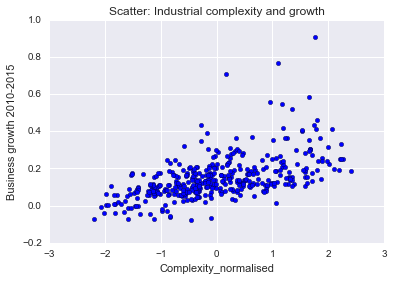

In [11]:
plt.scatter(complexity_2010_norm,business_growth_2010_2015)
plt.xlabel('Complexity_normalised')
plt.ylabel('Business growth 2010-2015')
plt.title('Scatter: Industrial complexity and growth')

In [12]:
#Generate additional outputs for James

#Extract product complexity
product_complexity = eci_algorithm_simplified(binary_spec_lqs[5],iterations=15)
product_complexity_2015_2 = pd.DataFrame(
    product_complexity[15][1].sort_values(ascending=False),columns=['Score'])
product_complexity_2015_2.ix[:,'Score']  = scipy.stats.zscore(product_complexity_2015_2.Score)

product_complexity_2015_2.to_csv('intermediate_outputs/product_complexity_2015.csv')

#Growth 2010_2015

business_growth_2010_2015.to_csv('../../temp_data_files/business_growth_11_15.csv')
idbr_business_counts[5].to_csv('../../temp_data_files/business_counts_2015.csv')


In [13]:
#Growth 2010_2015 for all sectors (for James)
growth_2010_15_all = idbr_business_counts[5].ix[:,1:]/idbr_business_counts[0].ix[:,1:]
growth_2010_15_all_df = growth_2010_15_all - 1
growth_2010_15_all_df.fillna(value=0,inplace=True)

growth_2010_15_all_df.index = idbr_business_counts[0].ix[:,0]

growth_2010_15_all_df.to_csv("../../temp_data_files/business_growth_10_15.csv")


## 2. Model

In [14]:
#Strategy
#Add neighbor activity variables; re-run models and consider changes in performance.
#Select 3 models:
    #Random forests
    #Support Vector Machines
    #Neural Nets
#Consider parameters to tune in each of the models, and do it. Graph changes in performance.

In [15]:
#Initial EDA
#Focus on 2011-15 changes.
#How many areas gained specialisation in a sector of at least 5%
sector_spec_gains = all_yr_lq_gains.ix[:,:-1].sum().sort_values(ascending=False)/(len(lad_set)*6)
sector_spec_gains.head()

manufacture_paper             0.518062
manufacturing_misc            0.472906
manufacture_plastic           0.470443
services_automotive           0.445813
services_agriculture_rural    0.440066
dtype: float64

In [16]:
#Create neighbourhood measures
#Get Shapefile here:
#https://geoportal.statistics.gov.uk/Docs/Boundaries/Travel_to_Work_Areas_(UK)_2011_boundaries_(generalised_clipped)_V3.zip
#Load shapefile
w = pysal.queen_from_shapefile(
    "../industry/data_input/Local_Authority_Districts_December_2015_Full_Clipped_Boundaries_in_Great_Britain/Local_Authority_Districts_December_2015_Full_Clipped_Boundaries_in_Great_Britain.shp")
#Load attributes of the shapefile
lad_attr = pysal.open(
    "../industry/data_input/Local_Authority_Districts_December_2015_Full_Clipped_Boundaries_in_Great_Britain/Local_Authority_Districts_December_2015_Full_Clipped_Boundaries_in_Great_Britain.dbf")


Island ids:  [45, 51, 331, 339, 342, 358]


In [17]:
#Create a lookup between ids and names
#w.neighbors
neighbor_lookup = pd.DataFrame({'id':lad_attr.by_col('OBJECTID'),
                                'name':lad_attr.by_col('LAD15NM')})
#0 indices in Python!
neighbor_lookup['id'] = neighbor_lookup['id']-1

#NB the shapefile is missing NI lads, and there is a small number of differences in labels. We 
#will change them in the lookup. NB we will train the model without NI but use it for prediction later.
mislabelled = list(set(neighbor_lookup['name'])-set(lad_set))

relabel_dict = {in_shape:in_idbr for in_shape,in_idbr in
                zip(mislabelled,['The Vale of Glamorgan','Anglesey','Edinburgh, City of',
                                                     'Rhondda, Cynon, Taff','King`s Lynn and West Norfolk',
                                                     'Eilean Siar'])}

neighbor_lookup['name_fixed'] = [relabel_dict[x] if x in relabel_dict.keys() else x for x
                           in neighbor_lookup['name']]

#We use the same approach as before to produce year on year versions:
all_yr_neighbors = pd.concat([extract_neighbor_specs(x).sort(columns='lad_name') for x in cluster_lqs[:-1]])
all_yr_neighbors.fillna(value=0,inplace=True)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:21: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [18]:
#Extract output and features NB here we are using lad name to sort the observations in the name order

#Outputs
all_yr_lq_gains = pd.concat([gain_specialisation(x,y,threshold=0) for x,y in zip(cluster_lqs[:-1],
                                                                   cluster_lqs[1:])])
#Subset to only include the LADs in the neighbourhood df
all_yr_lq_gains_subset = all_yr_lq_gains[[x in set(neighbor_lookup.name_fixed) for x
                                         in all_yr_lq_gains['lad_name']]]

#Features
all_yr_lq = pd.concat([x for x in cluster_lqs[:-1]])

#Subset to only include the LADs in the neighbourhood df
all_yr_lq_subset = all_yr_lq[[x in set(neighbor_lookup.name_fixed) for x
                                         in all_yr_lq['lad_name']]]

#LAD names
lad_set_subset = set(neighbor_lookup.name_fixed)


In [19]:
#Remove lad_name variable
#Features
all_yr_neigh_num = all_yr_neighbors.drop('lad_name',axis=1).reset_index(drop=True)
all_yr_lq_num = all_yr_lq_subset.drop('lad_name',axis=1).reset_index(drop=True)

X = np.array(pd.concat([all_yr_lq_num,all_yr_neigh_num],axis=1))

#Outputs
all_yr_lq_gains_num = all_yr_lq_gains_subset.drop('lad_name',axis=1).reset_index(drop=True)
Y = np.array(all_yr_lq_gains_num)

In [20]:
#Some simple analysis of path dependence. What is the relation between specialisation in t0 and 
    #growth in t1
#Link between clustering in t0 and growth in t1 using the binary growth variable

clust_vs_growth_df = pd.concat([pd.melt(all_yr_lq_gains_num),pd.melt(all_yr_lq_num)],axis=1).ix[:,[0,1,3]]
clust_vs_growth_df.columns=['sector','growth','esp']

clust_vs_growth_df.groupby(['growth'])['esp'].describe()

#Those area-sectocr pairs that grew tended to have stronger level of concentration in the first period.
#This is consistent with the idea of path dependence. Is this particular strong for some sectors?

growth       
0       count    75143.000000
        mean         0.861572
        std          3.088382
        min          0.000000
        25%          0.000000
        50%          0.591013
        75%          1.126040
        max        372.898551
1       count    42657.000000
        mean         1.183857
        std          2.965476
        min          0.000000
        25%          0.601775
        50%          0.903822
        75%          1.264941
        max        270.359211
Name: esp, dtype: float64

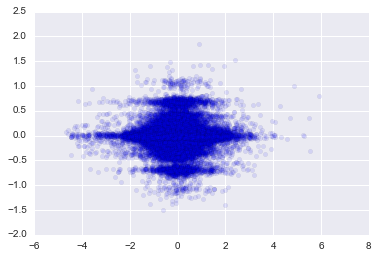

In [21]:
#Now, consider actual growth rates in LQs
all_yr_lq_gains_cont = pd.concat([change_specialisation(x,y) for x,y in zip(cluster_lqs[:-1],
                                                                   cluster_lqs[1:])])
all_yr_lq_gains_cont.fillna(value=0,inplace=True)

clust_vs_growth_cont_df = pd.concat([pd.melt(all_yr_lq_gains_cont.ix[:,:-1]),pd.melt(all_yr_lq_num)],axis=1).ix[:,[0,1,3]]
clust_vs_growth_cont_df.columns=['sector','growth','esp']

plt.scatter(np.log(clust_vs_growth_cont_df.esp),
            np.log(clust_vs_growth_cont_df.growth),alpha=0.1)

In [23]:
growth_corr_container = []

for i in set(clust_vs_growth_cont_df.sector):
    select_df = clust_vs_growth_cont_df[[x==i for x in clust_vs_growth_cont_df.sector]]
    sector_corr = select_df.ix[:,['growth','esp']].corr().ix[0,1]
    growth_corr_container.append(pd.DataFrame({'sector':i,'correlation':sector_corr},index=[1]))
    
growth_corr_df = pd.concat(growth_corr_container).reset_index(drop=True)
growth_corr_df.sort_values('correlation',ascending=False).head()

#No clear correlation between specialisation and growth in specialisation. Perhaps unsurprising:
#Less specialised areas are starting from a smaller base

,correlation,sector
17,0.093651,services_energy
59,0.061452,services_transport_storage
28,0.053148,services_freight_transport
22,0.052544,manufacture_furniture
27,0.046628,manufacture_metallurgy_misc


In [24]:
#Set number of cross validation folds
cv = 3

#Set the scoring metric.
#Need to decide which metric to use
aps = make_scorer(recall_score,average='macro')

In [31]:
def get_top_sectors(city,prediction_df,threshold=5):
    select = prediction_df.ix[city,:].sort_values(ascending=False)[:threshold]
    return(select)

In [33]:
#Modelling: Logistic regression

#Initialise the logit model. We use Logistic Regression CrossValidation, which creates a grid of C (regularisation)
#scores and selects the best performing one. Regularisation seeks to avoid overfitting by penalising large coefficients
#and removing variables (inducing sparsity).
#The class weight parameter is increasing the weight of less frequent classes to increase the level of information
    #to predict their outcomes.
    
log_clf = multiclass.OneVsRestClassifier(linear_model.LogisticRegressionCV())

#log_cv_scores = cross_validation.cross_val_score(log_clf,X,Y,cv=3,scoring=aps)

parameters = {
    'estimator__Cs':[1,10,15],
    'estimator__class_weight':['balanced',None]          
}

log_clf_grid = grid_search.GridSearchCV(log_clf,param_grid = parameters,scoring=aps,cv=3)

#scores = cross_validation.cross_val_score(log_clf,X,Y,scoring=aps,cv=3)

log_clf_grid.fit(X,Y)

GridSearchCV(cv=3, error_score='raise',
       estimator=OneVsRestClassifier(estimator=LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0),
          n_jobs=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'estimator__class_weight': ['balanced', None], 'estimator__Cs': [1, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(recall_score, average=macro), verbose=0)

In [72]:
#Pickle the model
joblib.dump(log_clf_grid,'models/rf_grid_clf.pkl')

In [86]:
#Now we have the model outputs
#Load the lad_region_lookup
lad_region_lookup = pd.read_csv('../../intermediate_outputs/lad_region_lookup.csv')


predictions_df = pd.DataFrame(log_clf_grid.best_estimator_.predict(input_pred),
                              index=sorted(lad_set_subset),  
                              columns=sector_set).reset_index(drop=False)

predictions_regions = pd.merge(lad_region_lookup,predictions_df,
                              left_on='lad_name',right_on='index')[['Region']+list(predictions_df.columns[1:])]

sector_distr_region = predictions_regions.groupby('Region')[list(predictions_df.columns[1:])].mean().reset_index()

#Reorder for plotting
sector_distr_region = sector_distr_region[['Region']+list(product_complexity_2015_2.index)]

#Write out to plot in R
sector_distr_region.to_csv('outputs/mean_region_specialisation.csv',index=False)

In [41]:
#This does as above: Generate recommendations and probabilities for different classes based on the
    #situation in the last period, and the best performing model.
predictions_df = pd.DataFrame(log_clf_grid.best_estimator_.predict(input_pred),
                              index=sorted(lad_set_subset),  
                              columns=sector_set)
prediction_probs_log = pd.DataFrame(log_clf_grid.best_estimator_.predict_proba(input_pred),
                                    index=sorted(lad_set_subset),columns=sector_set)

prediction_probs_log.to_csv("intermediate_outputs/prediction_probabilities.csv")

get_top_sectors('Cardiff',prediction_df=prediction_probs_log,threshold=10)

manufacture_machinery           0.837749
services_computing              0.821971
services_health                 0.800123
services_cleaning_facilities    0.781017
services_travelling_tourism     0.779607
services_finance_real_state     0.773140
manufacture_paper               0.766191
construction                    0.731387
manufacture_textiles            0.723667
services_r_and_d                0.714047
Name: Cardiff, dtype: float64